[0, 32400]
[0.00000000e+00 3.60040004e+00 7.20080009e+00 ... 3.23927992e+04
 3.23963996e+04 3.24000000e+04]
Starting ODE solver...
Calculating theta_dot at t=0.0
Calculating theta_dot at t=5.003830169660757e-11
Calculating theta_dot at t=0.0
Calculating theta_dot at t=0.0
Calculating theta_dot at t=0.0
Calculating theta_dot at t=0.0
Calculating theta_dot at t=0.0
Calculating theta_dot at t=0.0
Calculating theta_dot at t=0.0
Calculating theta_dot at t=0.0
Calculating theta_dot at t=0.0
Calculating theta_dot at t=0.0
Calculating theta_dot at t=0.0
Calculating theta_dot at t=0.0
Calculating theta_dot at t=0.0
Calculating theta_dot at t=0.0
Calculating theta_dot at t=6.789324117015831e-13
Calculating theta_dot at t=6.789324117015831e-13
Calculating theta_dot at t=1.3578648234031662e-12
Calculating theta_dot at t=1.3578648234031662e-12
Calculating theta_dot at t=8.147188940418998e-12
Calculating theta_dot at t=8.147188940418998e-12
Calculating theta_dot at t=1.493651305743483e-11
Calculatin

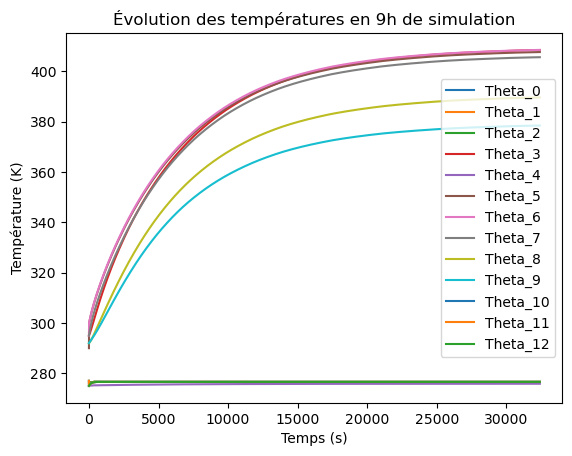

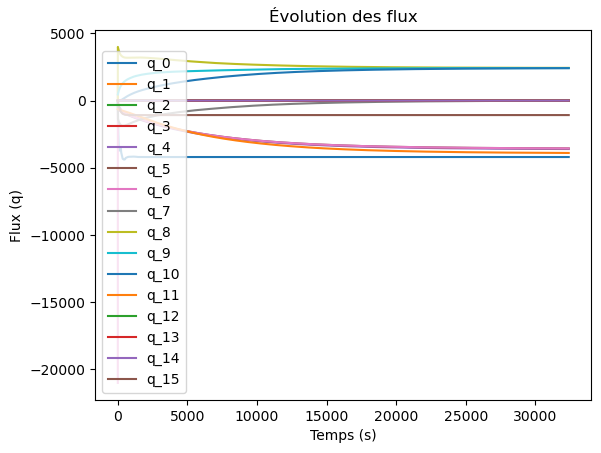

2000-02-01 00:00:00 	start date
2000-02-01 23:59:59 	end date
2000-02-01 00:00:00 	start date
2000-02-01 23:59:59 	end date
A:
      θ0   θ1   θ2   θ3   θ4   θ5   θ6   θ7
q0   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
q1  -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
q2   0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0
q3   0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0
q4   0.0  0.0  0.0 -1.0  1.0  0.0  0.0  0.0
q5   0.0  0.0  0.0  0.0 -1.0  1.0  0.0  0.0
q6   0.0  0.0  0.0  0.0 -1.0  0.0  1.0  0.0
q7   0.0  0.0  0.0  0.0  0.0 -1.0  1.0  0.0
q8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
q9   0.0  0.0  0.0  0.0  0.0  1.0  0.0 -1.0
q10  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
q11  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0 

G:
q0     1125.000000
q1      630.000000
q2      630.000000
q3       30.375000
q4       30.375000
q5       44.786824
q6      360.000000
q7       72.000000
q8      165.789474
q9      630.000000
q10       9.000000
q11    1000.000000
Name: G, dtype: float64 

C:
θ0           0.0
θ1    18216000.0
θ2   

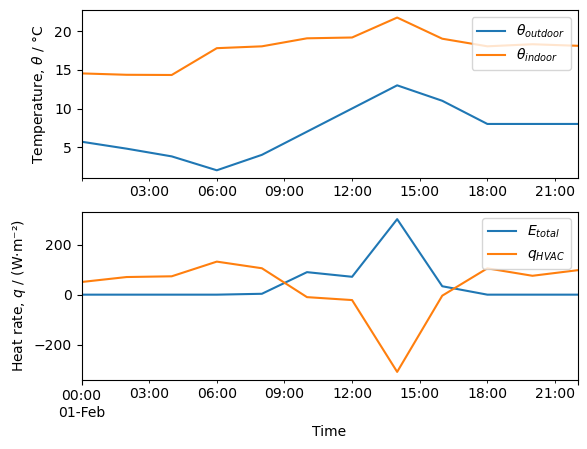

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import dm4bem
#import control as ctrl
import time
import pandas as pd


# Bibliothèques:
import numpy as np


# Variables :
nq, n0 = 16, 13  # number of flow-rates branches and of temperaure nodes
h0, hi, hw = 25, 8, 1.3 #W/m2/K, outside, inside and windows
lamdaw, lamdai = 1.4, 0.027 #W/m/K of the wall/glass and insulation/air
L, H, Hw, ww, wi = 3, 3, 2, 0.25, 0.05 #m, longueur, hauteur, hauteur fenetre, epaisseur mur et isolant
wwind, wair = 0.004, 0.012 #m, epaisseur du verre et de la couche d'air
ACH = 2 #2/hour, air change per hour in room 2, ventilation
T0 = 275 #K
Tr = 292 #K
Tb = 295 #K
E = 200 #W/m2
alpham = 0.2 #short wave absorbtion for a white wall
alphaw = 0.02 #short wave absorbtion for a glass
σ = 5.67e-08 #W/(m²⋅K⁴)
T_int = 293.15 #K
epsw = 0.9 #long wave emissivity for glass
epsb = 0.85 #long wave emissivity for wall
rhob = 2800 #kg/m3, masse volumique du béton
cb = 2300 #J/kg/K, chaleur spécifique du béton
rhoi = 20 #kg/m3, masse volumique de la laine de verre = isolant
ci = 1210 #J/kg/K, chaleur spécifique de l'isolant
rhog = 2530 #kg/m3, masse volumique du verre
cg = 2500 #J/kg/K, chaleur spécifique du verre
rhoa = 1.3 #kg/m3, masse volumique de l'air
ca = 966 #J/kg/K, chaleur spécifique de l'air


# calcul des surfaces de contact en m2 :
Sb = 13*L*H - 2*Hw*L #mur bleu
Sr = 3*L*H #mur rose
Swind = 2*L*Hw #2 fenetres
Sint = 3*L*H #mur intérieur entre rose et bleu


# Matrice d'incidence
A = np.zeros([nq,n0])
A[0,0] = A[1,0] = A[2,2] = A[3,3] = A[4,4] = A[5,5] = A[6,6] = A[7,6] = A[8,7] = A[9,8] = A[10,9] = A[11,9] = A[12,9] = A[13,10] = A[14,11] = A[15,12] = 1
A[1,1] = A[2,1] = A[3,2] = A[7,3] = A[5,4] = A[6,5] = A[8,6] = A[9,7] = A[10,8] = A[12,10] = A[13,11] = A[14,12] = -1


# Matrice de conductance, diagonale
G = np.zeros(A.shape[0])


# Long wave radiation
#Ici je suppose T_int = 20°C pour imposer 4σT³. Si autre température :
""" T_int = 273.15 + np.array([0, 40])
coeff = np.round((4 * σ * T_int**3), 1)
print(f'For 0°C < (T/K - 273.15)°C < 40°C, 4σT³/[W/(m²·K)] ∈ {coeff}')


T_int = 273.15 + np.array([10, 30])
coeff = np.round((4 * σ * T_int**3), 1)
print(f'For 10°C < (T/K - 273.15)°C < 30°C, 4σT³/[W/(m²·K)] ∈ {coeff}')


T_int = 273.15 + 20
coeff = np.round((4 * σ * T_int**3), 1)
print(f'For (T/K - 273.15)°C = 20°C, 4σT³ = {4 * σ * T_int**3:.1f} W/(m²·K)') """
cnst = 5.7 #W/(m²·K), la valeur de 4σT³
Fwb = Sb/Swind #facteur de forme entre la window et le blue wall, d'après le cours
Gb = cnst*Sb*epsb/(1-epsb)
Gw = cnst*Swind*epsw/(1-epsw)
Gbw = cnst*Fwb*Swind
G7 = 1/(1/Gb+1/Gbw+1/Gw)


# convection extérieur :
G[0] = h0*Sb
G[8] = hi*Sb
G[10] = hi*Sr
G[15] = h0*Sr


# Conduction :
G[1] = lamdaw*Sb/ww
G[2] = lamdai*Sb/wi
G[3] = 0
G[4] = lamdaw*Swind/wwind
G[5] = lamdai*Swind/wair
G[6] = G[4]
G[9] = lamdaw*Sint/ww
G[11] = rhoa*ca*(ACH*2*L**2*H)/3600
G[12] = 0
G[13] = lamdai*Sr/wi
G[14] = lamdaw*Sr/ww


# Advection :
G[7] = G7


# Vecteur de températures sources
b = np.zeros(A.shape[0])
b[0] = b[4] = b[11] = b[15] = T0


# Vecteur de sources rayonnantes
f = np.zeros(A.shape[1])
phi0b = alpham*E*Sb #blue wall
phi0r = alpham*E*Sr #pink wall
phia = alphaw*E*Swind #glass
f[0], f[4], f[12] = phi0b, phia, phi0r
chaufb = 6000 #W, chauffage pièce bleu
chaufr = 1500 #W, chaufffage pièce rose
f[6] = chaufb
f[9] = chaufr




# Output matrix
y = np.zeros(A.shape[1])
y[6] = y[9] = 1


# Matrice de conductances
C = np.zeros(A.shape[1])
C[1] = rhob*cb*ww*Sb #blue wall
C[2] = rhoi*ci*wi*Sb #isolant mur bleu
C[5] = rhog*cg*2*wwind*Swind #verre de la vitre
C[6] = rhoa*ca*wair*Swind #air dans la vitre
#C[9] = rhob*cb*ww*Sint #mur intérieur
C[10] = rhoi*ci*wi*Sr #isolant mur rose
C[11] = rhob*cb*ww*Sr #mur rose


C[C==0] = 1e-5
"""Pour éviter que la matrice ne soit pas inversible, on remplace les valeurs nulles par des petites valeurs"""


# Diagonalisation de la matrice C
C = np.diag(C)


# Fonction pour l'équation différentielle
def ode_system(t, theta):
   print(f"Calculating theta_dot at t={t}")
   theta_dot = np.linalg.solve(np.linalg.inv(C), (-(A.T @ np.diag(G) @ A) @ theta + A.T @ np.diag(G) @ b + f))
   return theta_dot
"""t est un tableau de temps
theta est un tableau 2D où chaque ligne correspond à l'évolution temporelle d'un noeud de température. """


# Conditions initiales
theta0 = np.ones(n0)
theta0[0] = theta0[12] = theta0[4] = T0
theta0[1] = theta0[2] = theta0[10] = theta0[11] = 277
theta0[5] = 290
theta0[3] = theta0[6] = theta0[7] = Tb
theta0[9] = theta0[8] = Tr






""" # Intervalle de temps
λ = np.linalg.eigvals(A)        # eigenvalues of matrix As
print(λ)
# settling time
t_settle = 4 * max(-1 / λ)
print(t_settle)
#duration :
duration = np.ceil(t_settle / 3600) * 3600
La matrice A n'est pas carrée donc ce n'est pas possible d'avoir ces valeurs propres"""


# Intervalle de temps
t_span = [0, 32400]  # 9 heures
t_eval = np.linspace(t_span[0], t_span[1], 9000)
print(t_span)
print(t_eval)




# Solve the ODE
print("Starting ODE solver...")
solution = solve_ivp(ode_system, t_span, theta0, method= 'BDF', t_eval=t_eval)
print("ODE solver finished.")


"""
solve_ivp est une fonction de la bibliothèque SciPy pour résoudre un système d'équations différentielles ordinaires (ODE).
t_span : C'est un tuple définissant l'intervalle de temps pour la résolution.
t_eval : C'est un tableau spécifiant les points de temps où l'on souhaite évaluer la solution.
"""


# Extraction des résultats
theta = solution.y
t = solution.t


"""
theta : Les valeurs des variables d'état à chaque temps dans solution.t
t : les temps où la solution a été évaluée (correspondant à t_eval)
"""


# Calcul de q à partir de theta
q = np.zeros((len(G), len(t)))
for i in range(len(t)):
   q[:, i] = np.diag(G) @ (-A @ theta[:, i] + b)




# # Affichage des résultats pour theta
plt.figure()
plt.plot(t, theta.T)
plt.xlabel('Temps (s)')
plt.ylabel('Température (K)')
plt.title('Évolution des températures en 9h de simulation')
plt.legend([f'Theta_{i}' for i in range(n0)])




# # Affichage des résultats pour q
plt.figure()
plt.plot(t, q.T)
plt.xlabel('Temps (s)')
plt.ylabel('Flux (q)')
plt.title('Évolution des flux')
plt.legend([f'q_{i}' for i in range(nq)])
plt.show()


# print("b:", b)
# print("f:", f)
# print("G:", G)
# print("C:", np.diag(C))
# print("y:", y)
# print("A:", A)
# print("Shape theta:", np.shape(theta))
# print("θ:", theta)









###### 4 Inputs
   

start_date = '02-01 00:00:00'
end_date = '02-01 23:59:59'
start_date = '2000-' + start_date
end_date = '2000-' + end_date
print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

filename = 'FRA_Lyon.074810_IWEC.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]

# Temperature sources
To = weather['temp_air']

# total solar irradiance
wall_out = pd.read_csv('./walls_out.csv')
w0 = wall_out[wall_out['ID'] == 'w0']

surface_orientation = {'slope': w0['β'].values[0],
                       'azimuth': w0['γ'].values[0],
                       'latitude': 45}

rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, w0['albedo'].values[0])

Etot = rad_surf.sum(axis=1)

# solar radiation absorbed by the outdoor surface of the wall
Φo = w0['α1'].values[0] * w0['Area'].values[0] * Etot

# window glass properties
α_gSW = 0.02   # short wave absortivity: reflective  glass
τ_gSW = 0    # short wave transmitance: reflective blue glass
S_g = Swind        # m², surface area of glass


# solar radiation absorbed by the glass
Φa = α_gSW * S_g * Etot


#auxiliary (internal) sources
Qa = 0 * np.ones(weather.shape[0])

# Input data set
input_data_set = pd.DataFrame({'To': To,
                               'Φo': Φo, 'Qa': Qa, 'Φa': Φa,
                               'Etot': Etot})

input_data_set.to_csv('./input_data_set.csv')









####### 5 Perfect Controller



start_date = '02-01 00:00:00'
end_date = '02-01 23:59:59'
start_date = '2000-' + start_date
end_date = '2000-' + end_date
print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

filename = 'FRA_Lyon.074810_IWEC.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]

# Temperature sources
To = weather['temp_air']

# total solar irradiance
wall_out = pd.read_csv('./walls_out.csv')
w0 = wall_out[wall_out['ID'] == 'w0']

surface_orientation = {'slope': w0['β'].values[0],
                       'azimuth': w0['γ'].values[0],
                       'latitude': 45}

rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, w0['albedo'].values[0])

Etot = rad_surf.sum(axis=1)

# solar radiation absorbed by the outdoor surface of the wall
Φo = w0['α1'].values[0] * w0['Area'].values[0] * Etot

# window glass properties
α_gSW = 0.02   # short wave absortivity: reflective  glass
τ_gSW = 0    # short wave transmitance: reflective blue glass
S_g = Swind        # m², surface area of glass

# solar radiation absorbed by the indoor surface of the wall
Φi = τ_gSW * w0['α0'].values[0] * S_g * Etot


# solar radiation absorbed by the glass
Φa = α_gSW * S_g * Etot

# # indoor air temperature set-point
Ti_sp = pd.Series(20, index=To.index)


Ti_day, Ti_night = 19, 15

Ti_sp = pd.Series(
    [Ti_day if 6 <= hour <= 22 else Ti_night for hour in To.index.hour],
    index=To.index)

#auxiliary (internal) sources
Qa = 0 * np.ones(weather.shape[0])

# Input data set
input_data_set = pd.DataFrame({'To': To,'Ti_sp':Ti_sp,
                               'Φo': Φo,'Φi': Φo, 'Qa': Qa, 'Φa': Φa,
                               'Etot': Etot})

input_data_set.to_csv('./input_data_set.csv')
controller = True
Kp = 1e3    # W/°C, controller gain

neglect_air_capacity = True
neglect_glass_capacity = True

explicit_Euler = True

imposed_time_step = False
Δt = 3600    # s, imposed time step 




# MODEL
# =====
# Thermal circuits
TC = dm4bem.file2TC('./TC.csv', name='', auto_number=False)

# by default TC['G']['q11'] = 0 # Kp -> 0, no controller (free-floating
if controller:
    TC['G']['q11'] = Kp     # G11 = Kp, conductance of edge q11
                            # Kp -> ∞, almost perfect controller
if neglect_air_capacity:
    TC['C']['θ6'] = 0       # C6, capacity of vertex θ6 (air)
if neglect_glass_capacity:
    TC['C']['θ7'] = 0       # C7, capacity of vertex θ7 (glass) 

#State-space
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)
dm4bem.print_TC(TC)

λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
dtmax = 2 * min(-1. / λ)    # max time step for Euler explicit stability
dt = dm4bem.round_time(dtmax)

if imposed_time_step:
    dt = Δt

dm4bem.print_rounded_time('dt', dt)

# INPUT DATA SET
# ==============
input_data_set = pd.read_csv('./input_data_set.csv',
                             index_col=0,
                             parse_dates=True)
input_data_set

input_data_set = input_data_set.resample(
    str(dt) + 'S').interpolate(method='linear')
input_data_set.head()

# Input vector in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)
u.head()

# Initial conditions
θ0 = 20                   # °C, initial temperatures
θ = pd.DataFrame(index=u.index)
θ[As.columns] = θ0          # fill θ with initial valeus θ0

I = np.eye(As.shape[0])     # identity matrix

if explicit_Euler:
    for k in range(u.shape[0] - 1):
        θ.iloc[k + 1] = (I + dt * As) @ θ.iloc[k] + dt * Bs @ u.iloc[k]
else:
    for k in range(u.shape[0] - 1):
        θ.iloc[k + 1] = np.linalg.inv(
            I - dt * As) @ (θ.iloc[k] + dt * Bs @ u.iloc[k])
        
# outputs
y = (Cs @ θ.T + Ds @  u.T).T

Kp = TC['G']['q11']     # controller gain
S = 9                   # m², surface area of the toy house
q_HVAC = Kp * (u['q11'] - y['θ6']) / S  # W/m²
y['θ6']

data = pd.DataFrame({'To': input_data_set['To'],
                     'θi': y['θ6'],
                     'Etot': input_data_set['Etot'],
                     'q_HVAC': q_HVAC})

fig, axs = plt.subplots(2, 1)
data[['To', 'θi']].plot(ax=axs[0],
                        xticks=[],
                        ylabel='Temperature, $θ$ / °C')

axs[0].legend(['$θ_{outdoor}$', '$θ_{indoor}$'],
              loc='upper right')

data[['Etot', 'q_HVAC']].plot(ax=axs[1],
                              ylabel='Heat rate, $q$ / (W·m⁻²)')
axs[1].set(xlabel='Time')
axs[1].legend(['$E_{total}$', '$q_{HVAC}$'],
              loc='upper right')
plt.show()


